In [1]:
import os
import time
import math
import json
import random
import hashlib
import requests
import argparse
import geopy.distance
import numpy as np
import pandas as pd

import rasterio
import networkx as nx
import rasterio.features
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from scipy.ndimage import gaussian_filter
from scipy.spatial import Voronoi, voronoi_plot_2d


# Notes

Başlangıç konumundan 10 ar metre ilerlenerek yeni koordinat hesaplandığı için bitiş konumundan 10 metreye kadar sapma olabiliyor.
Hesaplamalarımızın sonucunda **23.3 kilometrelik** hesaplamada **3 metre güney**, **10 metre doğuya** doğru hesaplama hatası var.
**Hata oranı:** 0.047% yaklaşık 0.05%


# Const

In [2]:
MAPServiceURL = "http://localhost:8585/"
meters_of_cells_value = 10

# Classes

In [3]:
class MyCalculator:
    
    @staticmethod
    def CalculateNewPoint(Point, meter=10, degree=90):
        val = geopy.distance.distance(meters=meter).destination(Point, bearing=degree)
        return (val.latitude, val.longitude)

    @staticmethod
    def CalculateCoords(start_point, end_point):
        return (
            Point(start_point['longitude'], start_point['latitude']),
            Point(end_point['longitude'], start_point['latitude']),
            Point(start_point['longitude'], end_point['latitude'])
        )

    @staticmethod
    def CalculateMeters(start_point, end_point):
        return (
            geopy.distance.distance((start_point['latitude'], start_point['longitude']), (start_point['latitude'], end_point['longitude'])).meters,
            geopy.distance.distance((start_point['latitude'], start_point['longitude']), (end_point['latitude'], start_point['longitude'])).meters,
            geopy.distance.distance((start_point['latitude'], start_point['longitude']), (end_point['latitude'], end_point['longitude'])).meters
        )

    @staticmethod
    def CalculateCellCount(LeftToRightMeters, TopToBottomMeters, meters_of_cells_value):
        return (
            math.ceil(LeftToRightMeters / meters_of_cells_value),
            math.ceil(TopToBottomMeters / meters_of_cells_value)
        )
    
    @staticmethod
    def MoveToPos(start_point, cellSize, degree):
        arr = [start_point]
        index = 0
        position = start_point
        while(index < cellSize):
            val = MyCalculator.CalculateNewPoint((position["latitude"], position["longitude"]), 10, degree)
            position = {'longitude': val[1], 'latitude': val[0]}
            arr.append(position)
            index = index+1
        return arr

In [4]:
class MyMap:

    LRarr = []
    TBarr = []
    MapArray = [[]]

    def __init__(self, start_point, end_point, meters_of_cells_value):
        self.start_point = start_point
        self.end_point = end_point
        self.meters_of_cells_value = meters_of_cells_value
        (self.LeftToRightMeters, self.TopToBottomMeters, self.StartToEndDistanceMeters) = MyCalculator.CalculateMeters(start_point, end_point)
        (self.LeftToRightCellCount, self.TopToBottomCellCount) = MyCalculator.CalculateCellCount(self.LeftToRightMeters, self.TopToBottomMeters, meters_of_cells_value)
        self.LRarr = MyCalculator.MoveToPos(start_point, self.LeftToRightCellCount, 90)
        self.TBarr = MyCalculator.MoveToPos(start_point, self.TopToBottomCellCount, 180)
        self.CreateMap()

    def CreateMap(self):
        self.MapArray = np.zeros((len(self.TBarr), len(self.LRarr)))
    
    def SetVal(self, x, y, code):
        self.MapArray[y][x] = code

    def GetSize(self):
        #(lat, lon)
        return (len(self.TBarr), len(self.LRarr))
    
    def FirstPoint(self):
        return (0, 0)

    def LastPoint(self):
        #(x, y)
        return (len(self.LRarr)-1,len(self.TBarr)-1)

    def GetCoords(self, x, y= None):
        if(type(x) == type((1,1))):
            y = x[1]
            x = x[0]
        
        if 0 <= x >= len(self.LRarr):
            x = 0
        if 0 <= y >= len(self.TBarr):
            y = 0
        
        #(lat, lon)
        return {"latitude" : self.TBarr[y]["latitude"], "longitude" : self.LRarr[x]["longitude"]}
    
    def GetCoordsTuple(self, x, y= None):
        if(type(x) == type((1,1))):
            y = x[1]
            x = x[0]
        
        if 0 <= x >= len(self.LRarr):
            x = 0
        if 0 <= y >= len(self.TBarr):
            y = 0
        
        #(lat, lon)
        return (self.TBarr[y]["latitude"], self.LRarr[x]["longitude"])


# Functions

In [5]:
def Fetch(data):
    try:
        r = requests.post(MAPServiceURL, json=data)
        if(r.status_code == 200):
            data = r.json()
            return data
        else:
            return None
    except Exception as e:
        #print(e)
        return None

In [6]:
def GetWays(Code = None):
    if(Code == None):
        data = {
            "Command" : "GetWays",
            "Body" : {
            }
        }
    else:
        data = {
            "Command" : "GetWays",
            "Body" : {
                "Query" : {
                    "Code": Code
                }
            }
        }
    return Fetch(data)


In [7]:
def KoordinatHesapla(Start, To, Bolen = 1):
    #x-y
    if(type(Start) == type((1, 1))):
        Start = {
            "lat" : Start[0],
            "lon" : Start[1]
        }
    if(type(To) == type((1,1))):
        To = {
            "lat" : To[0],
            "lon" : To[1]
        }
    
    lat_distance = (geopy.distance.distance((Start['lat'], Start['lon']), (To['lat'], Start['lon'])).meters) / Bolen
    lon_distance = (geopy.distance.distance((Start['lat'], Start['lon']), (Start['lat'], To['lon'])).meters) / Bolen

    #Buradaki değerler Türkiyenin konumuna göre hesaplama yapar
    if To['lon'] < Start['lon']:
        lon_distance = -1 * lon_distance

    if To['lat'] > Start['lat']:
        lat_distance = -lat_distance

    return lon_distance, lat_distance

In [8]:
def remove_keys_from_dict(dict_list, keys_to_remove):
    for d in dict_list:
        # Her bir anahtar üzerinde dön
        for key in keys_to_remove:
            # Eğer anahtar varsa sil
            d.pop(key, None)
    return dict_list

# Controls

## System Argümanları

In [9]:
StartPos = {
    "latitude" : 38.47425964105113,
    "longitude" : 27.15561571801447
}
EndPos = {
    "latitude" : 38.429293622864904,
    "longitude" : 27.213051809764856
}

MainRoadStart = {
    "latitude" : 38.46866805877406,
    "longitude" : 27.15561571801447
}
MainRoadEnd = {
    "latitude" : 38.429293622864904,
    "longitude" : 27.21226859497387
}
ProjectName = "123456"

def is_running_in_jupyter():
    try:
        from IPython import get_ipython
        return get_ipython() is not None
    except ImportError:
        return False

def main():
    global ProjectName
    parser = argparse.ArgumentParser(description="")
    parser.add_argument("--startLat", type=str, help="Start Lat")
    parser.add_argument("--startLon", type=str, help="Start Lon")
    parser.add_argument("--endLat", type=str, help="End Lat")
    parser.add_argument("--endLon", type=str, help="End Lon")
    
    parser.add_argument("--mrStartLat", type=str, help="Main Road Start Lat")
    parser.add_argument("--mrStartLon", type=str, help="Main Road End Lon")
    parser.add_argument("--mrEndLat", type=str, help="Main Road End Lat")
    parser.add_argument("--mrEndLon", type=str, help="Main Road End Lon")
    
    parser.add_argument("--name", type=str, help="Name")

    args = parser.parse_args()

    StartPos["latitude"] = float(args.startLat)
    StartPos["longitude"] = float(args.startLon)
    EndPos["latitude"] = float(args.endLat)
    EndPos["longitude"] = float(args.endLon)

    ProjectName = args.name if args.name is not None else "123456"
    
    if(args.mrStartLat is not None and args.mrStartLon is not None):
        MainRoadStart["latitude"] = float(args.mrStartLat)
        MainRoadStart["longitude"] = float(args.mrStartLon)
    else:
        MainRoadStart["latitude"] = StartPos["latitude"]
        MainRoadStart["longitude"] = StartPos["longitude"]

    if(args.mrEndLat is not None and args.mrEndLon is not None):
        MainRoadStart["latitude"] = float(args.mrEndLat)
        MainRoadStart["longitude"] = float(args.mrEndLon)
    else:
        MainRoadStart["latitude"] = EndPos["latitude"]
        MainRoadStart["longitude"] = EndPos["longitude"]

if __name__ == "__main__":
    if is_running_in_jupyter() == False:
        main()

MainRoadStart = {
    "latitude" : min(MainRoadStart["latitude"], StartPos["latitude"]),
    "longitude" : min(MainRoadStart["longitude"], StartPos["longitude"])
}

MainRoadEnd = {
    "latitude" : max(MainRoadEnd["latitude"], EndPos["latitude"]),
    "longitude" : min(MainRoadEnd["longitude"], EndPos["longitude"])
}

In [10]:
IsMapServerResponseCorrect = False
while True:
    try:
        response = requests.get(MAPServiceURL)
        if response.status_code > 100 and response.status_code < 600:
            IsMapServerResponseCorrect = True
        break
    except requests.exceptions.RequestException as e:
        time.sleep(10)

# Calc

In [11]:
(TopLeft, TopRight, BottomLeft) = MyCalculator.CalculateCoords(StartPos, EndPos)
harita = MyMap(StartPos, EndPos, meters_of_cells_value)

In [12]:
Ways = GetWays()

if(Ways != None):
    expressions_to_remove = ["centerPoint", "_id", "description", "name", "tags", "__v", "_id", "sourceID"]
    Ways = Ways["Body"]["Way"]
    remove_keys_from_dict(Ways, expressions_to_remove)

In [13]:
GreenAreasPolygons = [] # 2
LivestockAreasPolygons = [] # 7
AgriculturalFieldsPolygons = [] # 8
MinesPolygons = [] # 9
RegionsPolygons = [] # 20

In [14]:
for way in Ways:
    
    MyPolygons = []
    for node in way["nodes"]:
        Coords = KoordinatHesapla((StartPos['latitude'], StartPos['longitude']), node, meters_of_cells_value)
        Coords = (round(Coords[0], 0), round(Coords[1], 0))
        MyPolygons.append(Coords)
        
    if(len(MyPolygons) < 4):
        continue

    p = Polygon(MyPolygons)
    if(way["code"] == "2"):
        GreenAreasPolygons.append(p)
    elif(way["code"] == "7"):
        LivestockAreasPolygons.append(p)
    elif(way["code"] == "8"):
        AgriculturalFieldsPolygons.append(p)
    elif(way["code"] == "9"):
        MinesPolygons.append(p)
    elif(way["code"] == "20"):
        RegionsPolygons.append(p)


In [15]:
ARR = np.zeros((len(harita.TBarr), len(harita.LRarr)), dtype=np.uint8)

GreenAreaMap = rasterio.features.rasterize(GreenAreasPolygons, default_value=2, out_shape=(len(harita.TBarr), len(harita.LRarr)))
LivestockMap = rasterio.features.rasterize(LivestockAreasPolygons, default_value=7, out_shape=(len(harita.TBarr), len(harita.LRarr)))
AgricultralMap = rasterio.features.rasterize(AgriculturalFieldsPolygons, default_value=8, out_shape=(len(harita.TBarr), len(harita.LRarr)))
MinesMap = rasterio.features.rasterize(MinesPolygons, default_value=9, out_shape=(len(harita.TBarr), len(harita.LRarr)))
RegionsMap = rasterio.features.rasterize(RegionsPolygons, default_value=20, out_shape=(len(harita.TBarr), len(harita.LRarr)))

In [16]:
GreenAreaMap = np.where(GreenAreaMap > 0, 1, GreenAreaMap)
LivestockMap = np.where(LivestockMap > 0, 1, LivestockMap)
AgricultralMap = np.where(AgricultralMap > 0, 1, AgricultralMap)
MinesMap = np.where(MinesMap > 0, 1, MinesMap)
RegionsMap = np.where(RegionsMap > 0, 1, RegionsMap)

green_area_list = GreenAreaMap.tolist()
livestock_list = LivestockMap.tolist()
agricultural_list = AgricultralMap.tolist()
mines_list = MinesMap.tolist()
regions_list = RegionsMap.tolist()

MapData = {
    "MetersOfCellsValue" : meters_of_cells_value,
    "StartPoint" : {
        "Lat" : StartPos["latitude"],
        "Lon" : StartPos["longitude"]
    },
    "EndPoint" : {
        "Lat" : EndPos["latitude"],
        "Lon" : EndPos["longitude"]
    },
    "CalculatedEndPoint" : {
        "Lat" : harita.GetCoordsTuple(harita.LastPoint())[0],
        "Lon" : harita.GetCoordsTuple(harita.LastPoint())[1]
    },
    "Lists" : {
        "GreenAreaMap": green_area_list,
        "LivestockMap": livestock_list,
        "AgriculturalMap": agricultural_list,
        "MinesMap": mines_list,
        "RegionsMap": regions_list
    }
}

# Verilerin İşlenmesi

Yukarda verilerin hepsi aktarıldı ve **MapData** içine aktarıldı.

In [17]:
import cv2
from tensorflow.keras.models import load_model

## Functions

In [18]:
def PrepareArray(myArray):
    target_size = 256
    if(myArray.shape < (256, 256)):
        return [cv2.resize(myArray, (256, 256), interpolation=cv2.INTER_LINEAR)]
    
    result = []
    rows, cols = myArray.shape

    rIndex = 0
    for r in range(0, rows, target_size):
        result.append([])
        for c in range(0, cols, target_size):
            arr = myArray[r:r+target_size, c:c+target_size]
            if arr.shape < (256, 256) and arr.size > 0:
                nArr = cv2.resize(arr, (256, 256), interpolation=cv2.INTER_LINEAR)
                arr = nArr
            result[rIndex].append(arr)
        rIndex = rIndex + 1
    
    return result

## Import

In [73]:
model = load_model('Model/4ArrCNNModel.keras')
targetMatrix = pd.read_json("Model/targetMatrix.json", orient='records')

## AI

### Preprocess

In [20]:
AgriArr = np.array(MapData["Lists"]["AgriculturalMap"], dtype=np.uint8)
GreenArr = np.array(MapData["Lists"]["GreenAreaMap"], dtype=np.uint8)
LivestockArr = np.array(MapData["Lists"]["LivestockMap"], dtype=np.uint8)
MinesArr = np.array(MapData["Lists"]["MinesMap"], dtype=np.uint8)

AgriArrSplited = PrepareArray(AgriArr)
GreenArrSplited = PrepareArray(GreenArr)
LivestockArrSplited = PrepareArray(LivestockArr)
MinesArrSplited = PrepareArray(MinesArr)

UnifiedMap = []

In [21]:
for y in range(len(AgriArrSplited)):
    for x in range(len(AgriArrSplited[y])):
        Arr = []
        Arr.append(AgriArrSplited[y][x])
        Arr.append(GreenArrSplited[y][x])
        Arr.append(LivestockArrSplited[y][x])
        Arr.append(MinesArrSplited[y][x])
        UnifiedMap.append(Arr)

In [22]:
for i in range(len(UnifiedMap)):
    Arr = []
    for y in range(len(UnifiedMap[i][0])):
        ArrY = []
        for x in range(len(UnifiedMap[i][0][y])):
            ArrY.append([UnifiedMap[i][0][y][x], UnifiedMap[i][1][y][x], UnifiedMap[i][2][y][x], UnifiedMap[i][3][y][x]])
        Arr.append(ArrY)
    UnifiedMap[i] = Arr

In [23]:
np.shape(UnifiedMap)

(4, 256, 256, 4)

In [87]:
Res = []
ResMatrix = []

for area in range(len(UnifiedMap)):
    argMax = np.argmax(model.predict(np.array([UnifiedMap[area]])))
    Res.append(argMax)

for r in range(len(Res)):
    matrix = targetMatrix["matrix"][Res[r]].copy()
    ResMatrix.append(matrix)

1/1 [==============================] - 0s 20ms/step


In [113]:
np.shape(ResMatrix)
ResMatrix = np.array(ResMatrix)

for i in range(len(ResMatrix)):
    ResMatrix[i][ResMatrix[i] == 1] = 255

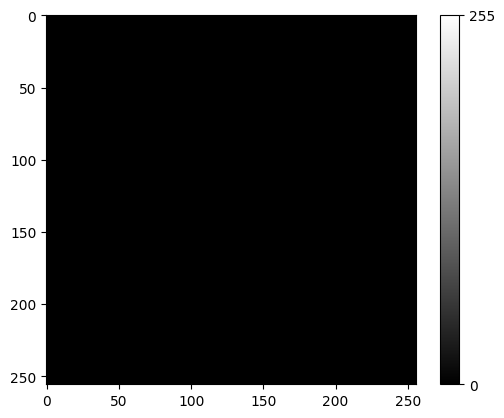

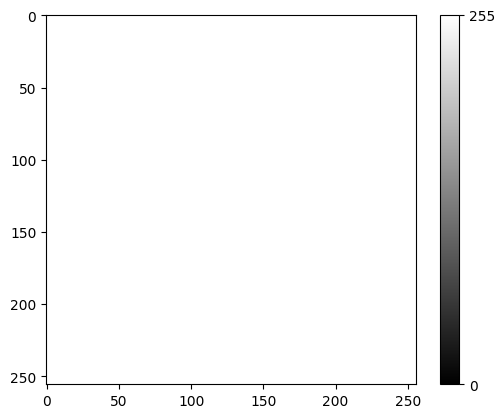

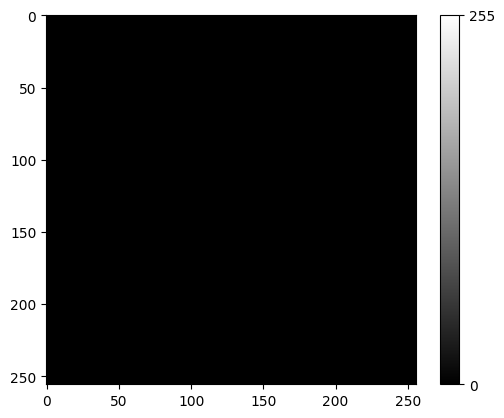

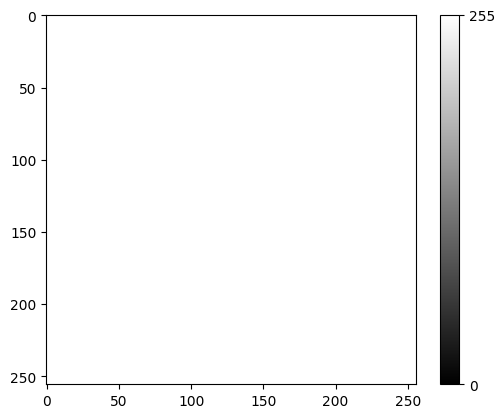

In [114]:
for i in range(ResMatrix.shape[0]):
    plt.imshow(ResMatrix[i], cmap='gray', vmin=0, vmax=255)
    plt.colorbar(ticks=[0, 255])
    plt.show()

In [117]:
ySize = xSize = math.sqrt(ResMatrix.shape[0])

sumMatrix = []
nnArr = []

for i in range(ResMatrix.shape[0]):
    if(i%xSize == 0 and i != 0):
        sumMatrix.append(nnArr)
        nnArr = []
    nnArr.append(ResMatrix[i])

sumMatrix.append(nnArr)
del nnArr

np.shape(sumMatrix)


(2, 2, 256, 256)

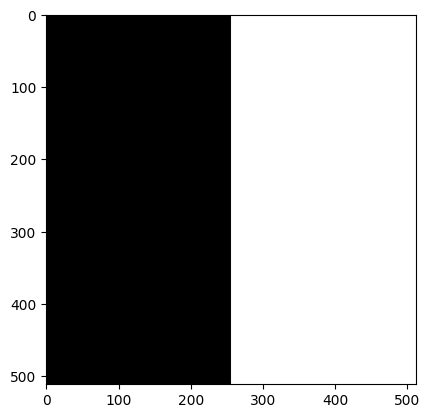

In [118]:
nArr = []
yVals = []
for y in range(len(sumMatrix)):
    xVals = []
    for x in range(len(sumMatrix[y])):
        xVals.append(sumMatrix[y][x])
    nArr.append(np.concatenate(xVals, axis=1))

nArr = np.array(nArr)
n2Arr = []
yVals = []
for y in range(len(nArr)):
    yVals.append(nArr[y])
n2Arr = np.concatenate(yVals, axis=0)
    
plt.imshow(n2Arr, cmap='gray')

### Gürültü Giderme

In [120]:
from scipy.ndimage import median_filter
import scipy.ndimage as ndimage

In [121]:
filtered_array = median_filter(n2Arr, size=25)

#plt.imshow(filtered_array, cmap='gray')

In [122]:
median_filtered = ndimage.median_filter(n2Arr, size=25)

gaussian_filtered = ndimage.gaussian_filter(n2Arr, sigma=5)

closed_image  = ndimage.binary_closing(n2Arr, structure=np.ones((25, 25)))

dilated_image = ndimage.binary_dilation(n2Arr, structure=np.ones((25, 25)))

filterSize = 15
CombinationalImage = ndimage.binary_closing(ndimage.binary_dilation(ndimage.median_filter(n2Arr, size=filterSize), structure=np.ones((filterSize * 2, filterSize * 2))), structure=np.ones((filterSize, filterSize)))


En iyi sonucun önce Median Filter sonra Binary Dilation sonra da Binary Closing ile verildiğine karar verdik.

In [123]:
n2Arr = CombinationalImage

# Oluşan Çıktıyı İşleme

In [124]:
from scipy.signal import convolve2d
# 10x10'luk ortalama filtresi oluşturma
filter_size = 10
average_filter = np.ones((filter_size, filter_size), dtype=float) / filter_size**2

result_array = convolve2d(n2Arr, average_filter, mode='valid')

#plt.imshow(result_array, cmap='gray')

In [125]:
n2TestArr = np.where(n2Arr > 0.75, 1, 0)
#plt.imshow(n2TestArr, cmap='gray')

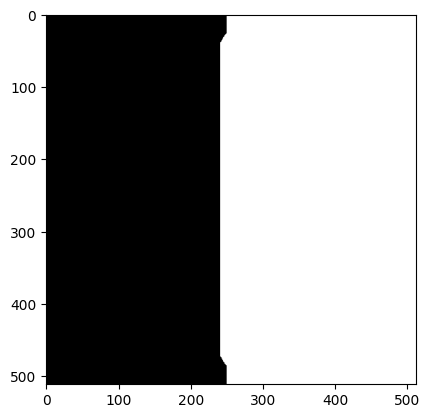

In [127]:
FinalImage = ndimage.median_filter(n2TestArr, size=64)
plt.imshow(FinalImage, cmap='gray', origin="upper")
plt.show()


# Elevation

In [128]:
ElevationAPIURL = "https://api.open-elevation.com/api/v1/lookup"
#ElevationAPIURL = "https://webhook.site/8c1fc351-61df-4aeb-a182-b3766defc14d"
ElevationAPIheaders = {
    'Accept': 'application/json',
    'Content-Type': 'application/json'
}

In [129]:
def clamp(num, minimum, maximum):
    return max(min(num, maximum), minimum)

def toRadians(degrees):
    return degrees * math.pi / 180

def lerp(value1, value2, alpha):
    return (value1 * (1 - alpha) + value2 * alpha)

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Dünya yarıçapı
    d_lat = toRadians(lat2 - lat1)
    d_lon = toRadians(lon2 - lon1)
    
    a = math.sin(d_lat / 2) * math.sin(d_lat / 2) + \
        math.cos(toRadians(lat1)) * math.cos(toRadians(lat2)) * \
        math.sin(d_lon / 2) * math.sin(d_lon / 2)
    
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

def convert_to_json(lat, lon):
    locations = []
    for y in range(len(lat)):
        for x in range(len(lon)):
            locations.append({
                "latitude": float(lat[y]),
                "longitude": float(lon[x])
            })

    result = {
        "locations": locations
    }

    return json.dumps(result, separators=(',', ':'), indent=None)

def xySetter(jsonVal, res):
    for i in range(len(jsonVal["results"])):
        jsonVal["results"][i]["x"] = i // res
        jsonVal["results"][i]["y"] = i % res
    return jsonVal

def get_elevation_data(URL, Headers, lat, lon, res):
    json_val = convert_to_json(lat, lon)
    try:
        response = requests.post(URL, data=json_val, headers={
                'Accept': 'application/json',
                'Content-Type': 'application/json',
                "Connection" : "close"
            }, timeout=60)
        response.raise_for_status()
        if response.status_code == 200:
            return xySetter(response.json(), res)
        else:
            raise Exception(f"Request failed with status: {response.status_code}")
    except Exception as e:
        #print(f"Error: {str(e)}")
        raise e

def generateElevationMap(URL, Headers, latRangeFirst, latRangeSecond, lonRangeFirst, lonRangeSecond, resolutionOfMap = 16, sensitivity = 2):
    resolutionOfMap = clamp(resolutionOfMap, 8, 1024)
    res = resolutionOfMap
    sensitivity = int(clamp(sensitivity, 0, 8))

    latRange = [latRangeFirst, latRangeSecond]
    lonRange = [lonRangeFirst, lonRangeSecond]

    lats = []
    lons = []

    for i in range(res):
        lat = lerp(latRange[0], latRange[1], i / (res - 1))
        lon = lerp(lonRange[0], lonRange[1], i / (res - 1))
        
        lats.append(round(lat, sensitivity))
        lons.append(round(lon, sensitivity))
    
    values = get_elevation_data(URL, Headers, lats, lons, res)
    return values

In [130]:
res = 164 #164
sens = 3 #3

lat1 = round(StartPos["latitude"], sens)
lat2 = round(EndPos["latitude"], sens)
lon1 = round(StartPos["longitude"], sens)
lon2 = round(EndPos["longitude"], sens)

llHash = str(lat1) + str(lat2) + str(lon1) + str(lon2)
llHash = hashlib.md5(llHash.encode('utf-8')).hexdigest()

elevationFName = llHash + ".json"

if os.path.isfile(elevationFName):
    #print("elevation founded.")
    with open(elevationFName) as f:
        vals = json.load(f)
else:
    #print("elevation created")
    vals = generateElevationMap(ElevationAPIURL, ElevationAPIheaders, lat1, lat2, lon1, lon2, res, sens)
    vals = vals["results"]

    with open(elevationFName, "w") as f:
        json.dump(vals, f)


# Yükseklik İşlemleri

In [131]:
df = pd.DataFrame(vals)

In [132]:
min_elevation = df['elevation'].min()
max_elevation = df['elevation'].max()

In [133]:
df['normalized_elevation'] = (df['elevation'] - min_elevation) / (max_elevation - min_elevation)

In [134]:
new_df = df[['x', 'y', 'normalized_elevation']]
res = int(math.sqrt(new_df.shape[0]))
res

164

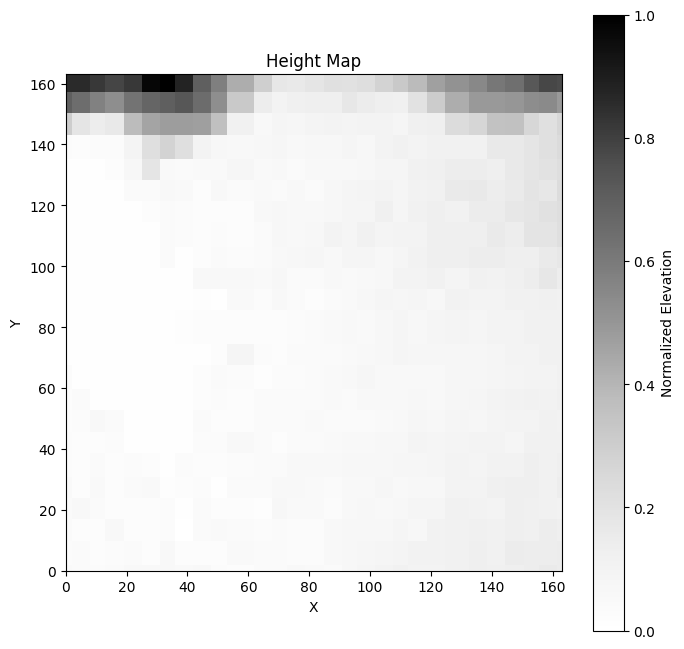

In [135]:

fig, ax = plt.subplots(figsize=(8, 8)) # 8,8 yerine res,res de gelebilir
#scatter = ax.scatter(df['x'], df['y'], c=df['normalized_elevation'], cmap='Greys', s=512)
im = ax.imshow(df.pivot(index='x', columns='y', values='normalized_elevation').values, cmap='Greys', origin="upper", extent=[df['y'].min(), df['y'].max(), df['x'].min(), df['x'].max()])

#plt.savefig('./test.png', dpi=1024)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Normalized Elevation')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Height Map')

plt.show()


In [136]:
df = df[['x', 'y', 'latitude', 'longitude', 'elevation', 'normalized_elevation']]

In [137]:
matrix_size = res
elevation_matrix = np.random.rand(matrix_size, matrix_size)
elevation_matrix = np.array(df['normalized_elevation']).reshape(matrix_size, matrix_size)


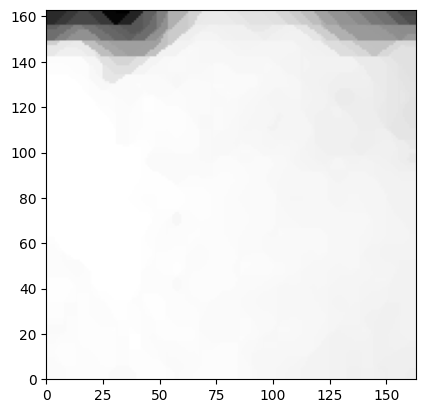

In [138]:
elevation_matrix = median_filter(elevation_matrix, size=10)

plt.imshow(elevation_matrix, cmap='Greys', origin="upper", extent=[df['y'].min(), df['y'].max(), df['x'].min(), df['x'].max()])
plt.show()


In [139]:
waterdf = pd.DataFrame(vals)

In [140]:
min_elevation = waterdf['elevation'].min()
max_elevation = waterdf['elevation'].max()

In [141]:
landscapeHeightThreshold = 0.1

waterdf["elevation"] = waterdf["elevation"].apply(lambda x: 0 if x >= landscapeHeightThreshold else 1)

min_elevation = waterdf["elevation"].min()
max_elevation = waterdf["elevation"].max()

waterdf["normalized_elevation"] = waterdf["elevation"]

In [142]:
new_waterdf = waterdf[['x', 'y', 'normalized_elevation']]

In [143]:
min_elevation = new_waterdf["normalized_elevation"].min()
max_elevation = new_waterdf["normalized_elevation"].max()
min_elevation_row = waterdf.loc[waterdf['elevation'].idxmin()]
max_elevation_row = waterdf.loc[waterdf['elevation'].idxmax()]

In [144]:
res = int(math.sqrt(df.shape[0]))
res

164

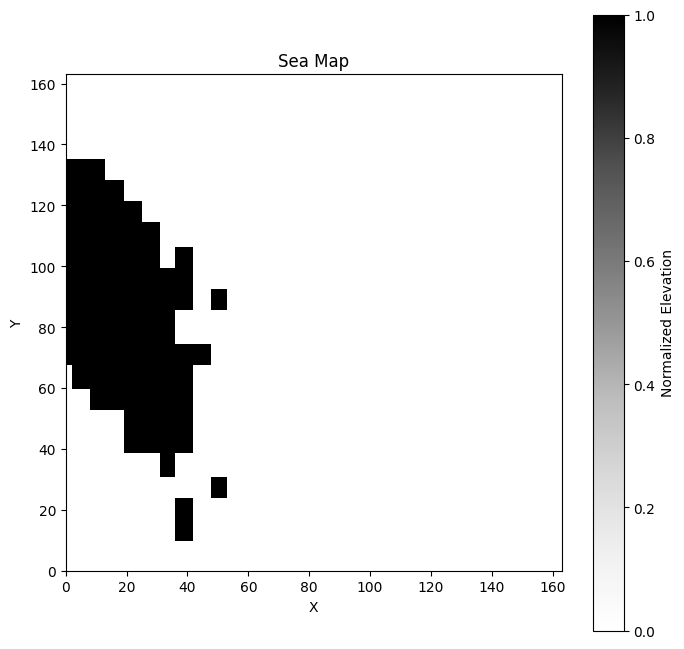

In [145]:

fig, ax = plt.subplots(figsize=(8, 8)) # 8,8 yerine res,res de gelebilir
im = ax.imshow(new_waterdf.pivot(index='x', columns='y', values='normalized_elevation').values, cmap='Greys', origin="upper", extent=[new_waterdf['y'].min(), new_waterdf['y'].max(), new_waterdf['x'].min(), new_waterdf['x'].max()])

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Normalized Elevation')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Sea Map')

plt.show()


In [146]:
matrix_size = res
waterMatrix = np.random.rand(matrix_size, matrix_size)
waterMatrix = np.array(new_waterdf['normalized_elevation']).reshape(matrix_size, matrix_size)

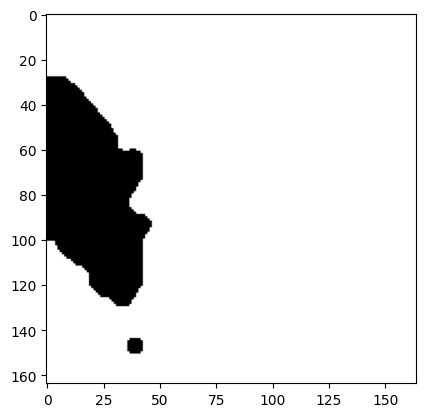

In [147]:
waterMatrix = median_filter(waterMatrix, size=10)

plt.imshow(waterMatrix, cmap="Greys")
plt.show()

In [148]:
scaled_image = (elevation_matrix * 255).astype(np.uint8)

edges = cv2.Canny(scaled_image, 50, 150)

'''
# Görüntüleri yan yana gösterme
plt.subplot(1, 2, 1), plt.imshow(scaled_image, cmap='Greys', origin="upper"), plt.title('Orijinal Gri Görüntü')
plt.subplot(1, 2, 2), plt.imshow(edges, cmap='Greys', origin="upper"), plt.title('Kenar Tespiti')
plt.show()
'''

'\n# Görüntüleri yan yana gösterme\nplt.subplot(1, 2, 1), plt.imshow(scaled_image, cmap=\'Greys\', origin="upper"), plt.title(\'Orijinal Gri Görüntü\')\nplt.subplot(1, 2, 2), plt.imshow(edges, cmap=\'Greys\', origin="upper"), plt.title(\'Kenar Tespiti\')\nplt.show()\n'

In [149]:
edgesMaxVal = edges.max()
edgesMinVal = edges.min()
edges = (edges - edgesMinVal) / (edgesMaxVal - edgesMinVal)

In [150]:
'''
plt.subplot(1, 2, 2), plt.imshow(edges, cmap='Greys', origin="lower"), plt.title('Kenar Tespiti')
plt.show()
'''

'\nplt.subplot(1, 2, 2), plt.imshow(edges, cmap=\'Greys\', origin="lower"), plt.title(\'Kenar Tespiti\')\nplt.show()\n'

In [151]:
tempLastMatrix = np.maximum(edges, waterMatrix)
'''
plt.subplot(1, 2, 2), plt.imshow(tempLastMatrix, cmap='Greys', origin="upper"), plt.title('Kenar Tespiti')
plt.show()
'''

'\nplt.subplot(1, 2, 2), plt.imshow(tempLastMatrix, cmap=\'Greys\', origin="upper"), plt.title(\'Kenar Tespiti\')\nplt.show()\n'

In [152]:
tempElevationMatrix = elevation_matrix * 0.8
tempLastMatrix = np.maximum(tempLastMatrix, tempElevationMatrix )
'''
plt.subplot(1, 2, 2), plt.imshow(tempLastMatrix, cmap='Greys', origin="upper"), plt.title('Kenar Tespiti')
plt.show()
'''

'\nplt.subplot(1, 2, 2), plt.imshow(tempLastMatrix, cmap=\'Greys\', origin="upper"), plt.title(\'Kenar Tespiti\')\nplt.show()\n'

In [153]:
tempElevationMatrix = elevation_matrix * 0.8
tempLastMatrix = np.maximum(tempLastMatrix, tempElevationMatrix )
ElevationAndWaterMatrix = np.maximum(waterMatrix, tempElevationMatrix )
'''
plt.subplot(1, 2, 2), plt.imshow(tempLastMatrix, cmap='Greys', origin="upper"), plt.title('Kenar Tespiti')
plt.show()
'''

'\nplt.subplot(1, 2, 2), plt.imshow(tempLastMatrix, cmap=\'Greys\', origin="upper"), plt.title(\'Kenar Tespiti\')\nplt.show()\n'

In [154]:
res = int(math.sqrt(df.shape[0]))
res

164

In [155]:
targetSize = FinalImage.shape
res = targetSize[0]
res2 = targetSize[1]

ElevationAndWaterMatrix = cv2.resize(ElevationAndWaterMatrix, (targetSize[::-1]), interpolation=cv2.INTER_LINEAR)
tempLastMatrix = cv2.resize(tempLastMatrix, (targetSize[::-1]), interpolation=cv2.INTER_LINEAR)
tempElevationMatrix = cv2.resize(tempElevationMatrix, (targetSize[::-1]), interpolation=cv2.INTER_LINEAR)

### Region Map ve Elevation

In [156]:
from scipy.interpolate import interp1d

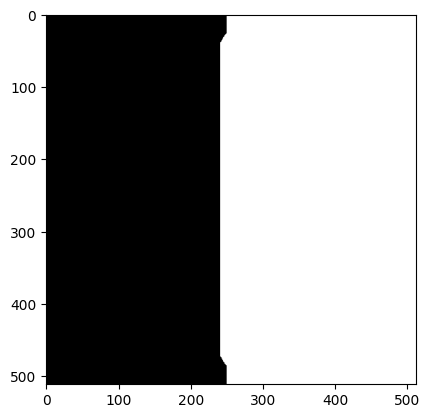

In [157]:

plt.imshow(FinalImage, cmap='gray', origin="upper")
plt.show()


In [158]:
GreenAreaMap = np.copy(MapData["Lists"]["GreenAreaMap"])
AgriculturalMap = np.copy(MapData["Lists"]["AgriculturalMap"])
LivestockMap = np.copy(MapData["Lists"]["LivestockMap"])

GreenAreaMapNew = median_filter(GreenAreaMap, 3)
AgriculturalMapNew = median_filter(AgriculturalMap, 3)
LivestockMapNew = median_filter(LivestockMap, 3)

filterSize = 2
GreenAreaMap = ndimage.binary_dilation(GreenAreaMap, structure=np.ones((filterSize * 2, filterSize * 2)))
AgriculturalMapNew = ndimage.binary_dilation(AgriculturalMapNew, structure=np.ones((filterSize * 2, filterSize * 2)))
LivestockMapNew = ndimage.binary_dilation(LivestockMapNew, structure=np.ones((filterSize * 2, filterSize * 2)))

GreenAreaMapNewx = np.zeros(targetSize)
GreenAreaMapNewx[:GreenAreaMapNew.shape[0], :GreenAreaMapNew.shape[1]] = GreenAreaMapNew
GreenAreaMapNew = GreenAreaMapNewx

AgriculturalMapNewx = np.zeros(targetSize)
AgriculturalMapNewx[:AgriculturalMapNew.shape[0], :AgriculturalMapNew.shape[1]] = AgriculturalMapNew
AgriculturalMapNew = AgriculturalMapNewx

LivestockMapNewx = np.zeros(targetSize)
LivestockMapNewx[:LivestockMapNew.shape[0], :LivestockMapNew.shape[1]] = LivestockMapNew
LivestockMapNew = LivestockMapNewx

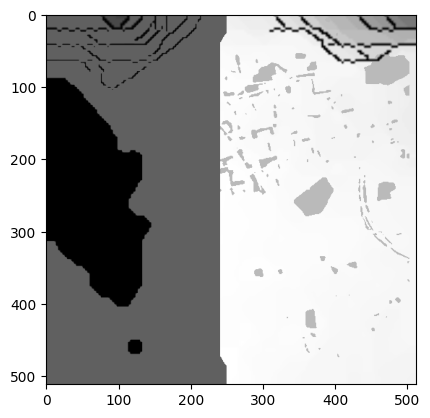

In [159]:
ResultImage = FinalImage.copy()
ResultImage = 1 - ResultImage
ResultImage = ResultImage * 0.7

GreenAreaMapNew = GreenAreaMapNew * 0.4
AgriculturalMapNew = AgriculturalMapNew * 0.4
LivestockMapNew = LivestockMapNew * 0.4

ResultImage = np.maximum(ResultImage, tempLastMatrix)
ResultImage = np.maximum(ResultImage, GreenAreaMapNew)
ResultImage = np.maximum(ResultImage, AgriculturalMapNew)
ResultImage = np.maximum(ResultImage, LivestockMapNew)

plt.imshow(ResultImage, cmap='Greys', origin="upper")
plt.show()


## Bölge Seçimi

In [160]:
def convert_to_coordinates(StartPos, EndPos, num_divisions, DotPos):
    start_latitude = StartPos["latitude"]
    end_latitude = EndPos["latitude"]
    start_longitude = StartPos["longitude"]
    end_longitude = EndPos["longitude"]
    temp_latitude = DotPos["latitude"]
    temp_longitude = DotPos["longitude"]

    # Latitude ve Longitude aralıklarını hesapla
    lat_interval = (end_latitude - start_latitude) / num_divisions
    lon_interval = (end_longitude - start_longitude) / num_divisions
    
    # Verilen tempLatitude ve tempLongitude değerlerini x ve y koordinatlarına çevir
    x = min(num_divisions - 1 , int((temp_longitude - start_longitude) / lon_interval))
    y = min(num_divisions - 1 , int((temp_latitude - start_latitude) / lat_interval))
    
    x = max(0, x)
    y = max(0, y)
    
    return y, x


In [161]:
def FindPosInMatrix(StartPos, MainRoadStart):
    latD = geopy.distance.geodesic(
        (StartPos["latitude"], StartPos["longitude"]), (MainRoadStart['latitude'], StartPos['longitude'])
    ).meters
    lonD = geopy.distance.geodesic(
        (StartPos["latitude"], StartPos["longitude"]), (StartPos['latitude'], MainRoadStart['longitude'])
    ).meters

    return ( round(latD / meters_of_cells_value), round(lonD / meters_of_cells_value))

In [162]:
# İşlemeyi hzılandırmak için çözünürlüğü küçültüyoruz.

ResultImageScaled = ResultImage[::4, ::4]
tempLastMatrixScaled = tempLastMatrix[::4, ::4]
tempElevationMatrixScaled = tempElevationMatrix[::4, ::4]
waterMatrixScaled = waterMatrix[::4, ::4]
ElevationAndWaterMatrixScaled = ElevationAndWaterMatrix[::4, ::4]

waterMask = np.copy(ElevationAndWaterMatrixScaled)
waterMask = np.where(waterMask == 1, waterMask, 0)

In [163]:
GreenAreaMapScaled = GreenAreaMapNew[::4, ::4]
AgriculturalMapScaled = AgriculturalMapNew[::4, ::4]
LivestockMapScaled = LivestockMapNew[::4, ::4]

In [164]:
MainRoadStartIndexs = (convert_to_coordinates(StartPos, EndPos, ResultImageScaled.shape[0], MainRoadStart))
MainRoadEndIndexs = (convert_to_coordinates(StartPos, EndPos, ResultImageScaled.shape[0], MainRoadEnd))

In [165]:
res = tempLastMatrixScaled.shape[0]
res2 = tempLastMatrixScaled.shape[1]

G = nx.grid_2d_graph(res2, res)

lastI = 0
lastJ = 0
for (i, j) in G.nodes:
    G.nodes[(i, j)]['normalized_elevation'] = tempLastMatrixScaled[j, i]
    lastI = i
    lastJ = j

In [166]:
def cost_function(u, v, d):
    elev = G.nodes[v]['normalized_elevation']

    if(elev >= 0.98):
        return float("inf")
    return (G.nodes[v]['normalized_elevation'] + random.uniform(0, 0.02)) / 2

def cost_function_forroad(u, v, d):
    elev = G.nodes[v]['normalized_elevation']

    if(elev >= 0.98):
        return float("inf")
    return (G.nodes[v]['normalized_elevation'] + random.uniform(0, 0.08))

def cost_function_forroad2(u, v, d):
    elev = G.nodes[v]['normalized_elevation']
    elev = (G.nodes[v]['normalized_elevation'] + random.uniform(0, 0.1))
    if(elev >= 0.98):
        return float("inf")
    return elev

In [167]:
xy1 = MainRoadStartIndexs
xy2 = MainRoadEndIndexs

#path1 = nx.astar_path(G, xy1, xy2, heuristic=None, weight=cost_function)
path1 = nx.shortest_path(G, xy1, xy2, weight=cost_function, method="bellman-ford")

path_x1 = [j for i, j in path1]
path_y1 = [i for i, j in path1]

path_x, path_y = zip(*path1)
t1 = np.linspace(0, 1, len(path_x1))

degree = 3
bezier_x1 = interp1d(t1, path_x1, kind='cubic')
bezier_y1 = interp1d(t1, path_y1, kind='cubic')

t_smooth = np.linspace(0, 1, 100)
path_smooth_x1 = bezier_x1(t_smooth)
path_smooth_y1 = bezier_y1(t_smooth)
'''
plt.imshow(ResultImageScaled, cmap='gray', origin="upper")
plt.colorbar(label='Normalized Elevation')
plt.scatter(*xy1[::-1], color='red', marker='o', label='Main Road Start')
plt.scatter(*xy2[::-1], color='red', marker='o', label='Main Road End')
plt.plot(path_smooth_x1, path_smooth_y1, color='blue', linewidth=2, label='Main Road Path')
'''

'\nplt.imshow(ResultImageScaled, cmap=\'gray\', origin="upper")\nplt.colorbar(label=\'Normalized Elevation\')\nplt.scatter(*xy1[::-1], color=\'red\', marker=\'o\', label=\'Main Road Start\')\nplt.scatter(*xy2[::-1], color=\'red\', marker=\'o\', label=\'Main Road End\')\nplt.plot(path_smooth_x1, path_smooth_y1, color=\'blue\', linewidth=2, label=\'Main Road Path\')\n'

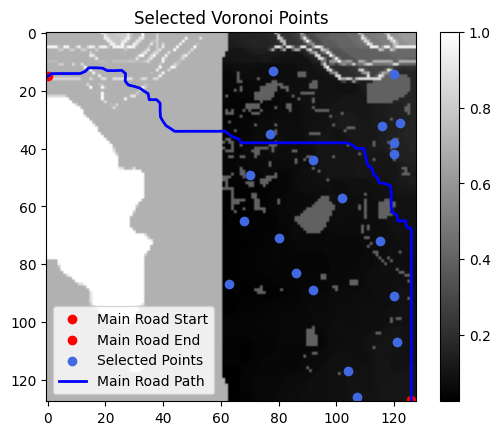

In [168]:
areaCount = 20 # Bölge Sayısı

indices = np.argwhere(ResultImageScaled < 0.5)
selected_indices = indices[np.random.choice(len(indices), size=areaCount, replace=False)]
x_coords, y_coords = selected_indices[:, 1], selected_indices[:, 0]

plt.scatter(*xy1[::-1], color='red', marker='o', label='Main Road Start')
plt.scatter(*xy2[::-1], color='red', marker='o', label='Main Road End')

plt.scatter(x_coords, y_coords, color='royalblue', label='Selected Points')

plt.plot(path_smooth_x1, path_smooth_y1, color='blue', linewidth=2, label='Main Road Path')
plt.imshow(ResultImageScaled, cmap='gray', origin='upper')
plt.title('Selected Voronoi Points')
plt.legend()
plt.colorbar()
plt.show()


In [169]:
points = np.column_stack((x_coords, y_coords))
vor = Voronoi(points)

In [170]:
def calculate_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

In [171]:
# [[x, y], [x, y]]
closesPointsOnPath = []

for point in selected_indices:
    min_distance = float('inf')
    ClosePointOnPath = None

    for pointOnPath in path1:
        FoundedPointOnPath = (pointOnPath[1], pointOnPath[0])
        distance = calculate_distance((point[1], point[0]), FoundedPointOnPath)
        if distance < min_distance:
            min_distance = distance
            ClosePointOnPath = FoundedPointOnPath

    closesPointsOnPath.append(ClosePointOnPath)

PathToPointFromMainRoad = []

tIndex = 0
for point, close_point_on_road in zip(selected_indices, closesPointsOnPath):
    TargetPoint = (point[1], point[0])
    source_node = tuple(map(int, close_point_on_road))

    if source_node not in G.nodes or TargetPoint not in G.nodes:
        continue

    path = nx.astar_path(G, source_node, TargetPoint, heuristic=None, weight=cost_function)
    PathToPointFromMainRoad.append(path)
    tIndex=tIndex+1

# Bir birinden sonra gelen yolları bir birine bağla
crossRoads = []
tIndex2 = 0
ConnectThisRoads = []
buff = []
for point in zip(selected_indices):
    if(random.uniform(0, 1.5) < 0.5):
        if(len(buff) > 1):
            ConnectThisRoads.append(np.copy(buff))
        buff.clear()
        continue
    else:
        buff.append((point[0][1], point[0][0]))
    
for group in ConnectThisRoads:
    i = 0
    while i < len(group) - 1:
        source_node = (group[i][0], group[i][1])
        TargetPoint = (group[i + 1][0], group[i + 1][1])
        i = i + 2
        if source_node not in G.nodes or TargetPoint not in G.nodes:
            continue
        path = nx.astar_path(G, source_node, TargetPoint, heuristic=None, weight=cost_function_forroad)
        crossRoads.append(path)
        tIndex2=tIndex2+1

In [172]:
def find_nearest_node(graph, target_node):
    nodes = list(graph.nodes)
    distances = np.linalg.norm(np.array(nodes) - np.array(target_node), axis=1)
    nearest_index = np.argmin(distances)
    nearest_node = nodes[nearest_index]
    return nearest_node

def FindPointsAndRegions(vor, selected_indicesScaled):
    allPaths = []
    for i, point in enumerate(selected_indicesScaled):
        myPoint = selected_indicesScaled[i]
        myPoint = [myPoint[1], myPoint[0]]
        region = FindRegion(vor, myPoint)
        vor_rv = vor.vertices[vor.regions[region]]

        verticiesArr = []
        for vert in vor_rv:
            vert1 = np.maximum((int(vert[1]) - 1), 0) #y
            vert0 = np.maximum((int(vert[0]) - 1), 0) #x

            if(vert1 >= ResultImageScaled.shape[1] or vert0 >= ResultImageScaled.shape[0]):
                continue

            if(ResultImageScaled[vert1][vert0] > 0.99):
                continue
            verticiesArr.append((vert0, vert1))

        for vert in verticiesArr:
            v = (vert[0], vert[1])
            mP = (int(myPoint[0]), int(myPoint[1]))

            dist = calculate_distance(v, mP)

            if( dist < 70 ):
                if mP not in G.nodes or v not in G.nodes:
                    continue
                path = nx.astar_path(G, mP, v, heuristic=None, weight=cost_function_forroad2)
                allPaths.append(path)
    return allPaths

def FindRegion(vor, point):
    region_index = vor.point_region[np.argmin(np.linalg.norm(vor.points - point, axis=1))]
    return region_index

In [173]:
PathsInsideInRegion = FindPointsAndRegions(vor, selected_indices)

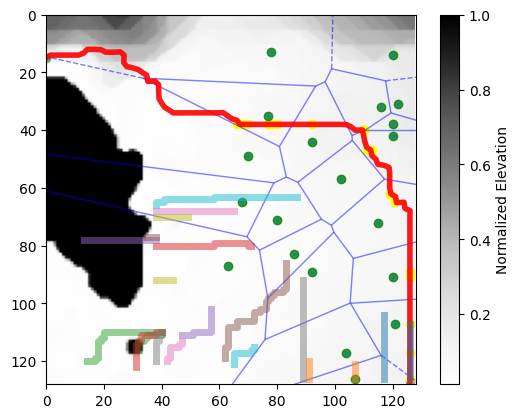

In [174]:
voronoi_plot_2d(vor, show_vertices=False, line_colors='blue', line_width=1, line_alpha=0.5, point_size=3)

plt.xlim(0, ElevationAndWaterMatrixScaled.shape[1])
plt.ylim(ElevationAndWaterMatrixScaled.shape[0], 0)

plt.imshow(ElevationAndWaterMatrixScaled, cmap='Greys', origin="upper")

plt.colorbar(label='Normalized Elevation')
plt.scatter(*xy1[::-1], color='green', alpha=0.5, marker='o', label=' Point')
plt.scatter(*xy2[::-1], color='purple', alpha=0.5, marker='o', label=' Point')

plt.plot(path_smooth_x1, path_smooth_y1, color='red', alpha=0.9, linewidth=4, label='Smoothed Path (Bezier Curve)') #YENI EKLENEN BEZIER

for i, path in enumerate(PathToPointFromMainRoad):
    path_x, path_y = zip(*[(p[1], p[0]) for p in path])  # Corrected coordinate order
    plt.scatter(*closesPointsOnPath[i], alpha=1, color='yellow', marker='o', label=' Point')
    plt.plot(path_x, path_y, linewidth=5, alpha=0.5, label=f'A* Path {i + 1}')

tempIndex = 0
for point in selected_indices:
    plt.scatter(point[1], point[0], alpha=0.8, color='green', marker='o', label=' Point')
    tempIndex = tempIndex + 1

plt.show()

In [175]:
#Scaled To Main Size

crossRoadsScaled = [[(4 * x[0], 4 * x[1]) for x in path] for path in crossRoads]
pathToPointPathsScaled = [[(4 * x[0], 4 * x[1]) for x in path] for path in PathToPointFromMainRoad]
mainRoadPath = [(4 * x[0], 4 * x[1]) for x in path1]

PathsInsideInRegionScaled = [[(4 * x[0], 4 * x[1]) for x in path] for path in PathsInsideInRegion]
selected_indicesScaled = selected_indices * 4

path_x1 = [j for i, j in mainRoadPath]
path_y1 = [i for i, j in mainRoadPath]

points = np.column_stack((x_coords, y_coords))
points = points * 4
vor = Voronoi(points)

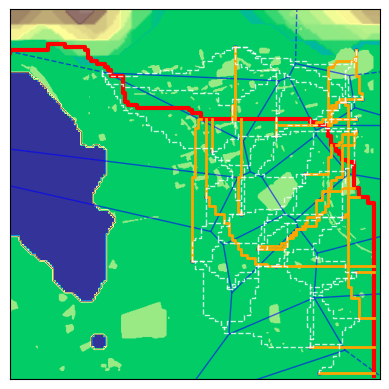

In [176]:
voronoi_plot_2d(vor, show_vertices=False, line_colors='blue', line_width=1, line_alpha=0.6, point_size=5)

RegionBorders = []

for regionIndex in vor.regions:
    if -1 not in regionIndex and len(regionIndex) > 0:
        region_points = vor.vertices[regionIndex]
        RegionBorders.append(region_points)

for i, region in enumerate(vor.regions):
    if -1 not in region and len(region) > 0:
        region_points = vor.vertices[region]
        region_center = np.mean(region_points, axis=0)

plt.xlim(0, ElevationAndWaterMatrix.shape[1])
plt.ylim(ElevationAndWaterMatrix.shape[0], 0)

rResultImage = np.copy(ElevationAndWaterMatrix)
rResultImage = np.maximum(rResultImage, GreenAreaMapNew)
rResultImage = np.maximum(rResultImage, AgriculturalMapNew)
rResultImage = np.where((rResultImage < 0.2), 0.25, rResultImage)
rResultImage = np.where(rResultImage == 1, 0, rResultImage)
plt.imshow(rResultImage, cmap='terrain', origin="upper")

#plt.colorbar(label='Normalized Elevation')

plt.plot(path_x1, path_y1, color='red', alpha=1, linewidth=3, label='Smoothed Path (Bezier Curve)')

for i, path in enumerate(pathToPointPathsScaled):
    path_x, path_y = zip(*path)
    plt.plot(path_x, path_y, linewidth=2, color="orange", alpha=1, label=f'A* Path {i + 1}')

for i, path in enumerate(crossRoadsScaled):
    path_x, path_y = zip(*path)
    plt.plot(path_x, path_y, linewidth=2, color="orange", alpha=1, label=f'A* Path {i + 1}')

for i, path in enumerate(PathsInsideInRegionScaled):
    path_x, path_y = zip(*path)
    plt.plot(path_x, path_y, linewidth=1, color="white", linestyle='--', alpha=0.8, label=f'A* Path {i + 1}')
    
tempIndex = 0
for point in selected_indicesScaled:
    closest_path_point = closesPointsOnPath[tempIndex]
    newPoint = [point[1], point[0]]
    source_node = (closest_path_point[1],closest_path_point[0])
    tempIndex = tempIndex + 1

pathToPointPathsScaled = [np.array(region).tolist() for region in pathToPointPathsScaled]
crossRoadsScaled = [np.array(region).tolist() for region in crossRoadsScaled]
RegionsToInside = [np.array(region).tolist() for region in PathsInsideInRegionScaled]


for Kat1 in range(len(RegionsToInside)):
    for Kat2 in range(len(RegionsToInside[Kat1])):
        RegionsToInside[Kat1][Kat2] = np.array(RegionsToInside[Kat1][Kat2]).tolist()

mRoad = np.array(path1)
mRoad = mRoad.tolist()

Elements = {
    "Regions" : [np.array(region).tolist() for region in RegionBorders],
    "MainRoadToRegionArea": pathToPointPathsScaled,
    "RegionsToRegions": crossRoadsScaled,
    "RegionsToInside": RegionsToInside,
    "MainRoad" : mRoad,
    "Maps" : {
        "Terrain" : {
            "Map" : rResultImage.tolist(),
            "Cmap" : "terrain"
        }
    }
}

JsonData = json.dumps(Elements, indent=2)

with open(ProjectName + "-data.json", "w") as jsonFile:
    jsonFile.write(JsonData)

plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.savefig(ProjectName + '-g.png', bbox_inches = "tight", dpi=300)

plt.show()

# İç bölgelerin oluşturulması

In [177]:
newAreaCount = areaCount * 2 / 3
newAreaCount = int(newAreaCount)

newIndices = np.argwhere(ResultImageScaled < 0.75)
selected_indices2 = indices[np.random.choice(len(indices), size=newAreaCount, replace=False)]
x_coords2, y_coords2 = selected_indices2[:, 1], selected_indices2[:, 0]

points2 = np.column_stack((x_coords2, y_coords2))

vor2 = Voronoi(points2)

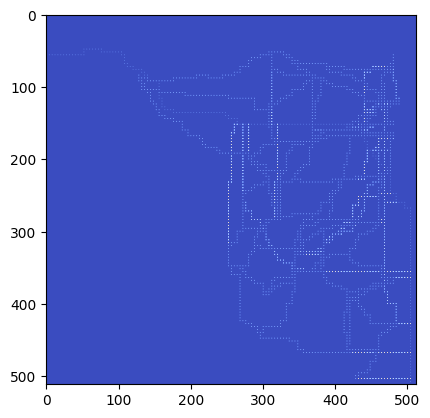

In [178]:
MainRoadMatrix = np.zeros((ElevationAndWaterMatrix.shape[0], ElevationAndWaterMatrix.shape[1]))
for x, y in zip(path_x1, path_y1):
    MainRoadMatrix[y, x] = 1

for i, path in enumerate(pathToPointPathsScaled):
    path_x, path_y = zip(*path)
    for x, y in zip(path_x, path_y):
        MainRoadMatrix[y, x] = 6
for i, path in enumerate(crossRoadsScaled):
    path_x, path_y = zip(*path)
    for x, y in zip(path_x, path_y):
        MainRoadMatrix[y, x] = 4
for i, path in enumerate(PathsInsideInRegionScaled):
    path_x, path_y = zip(*path)
    for x, y in zip(path_x, path_y):
        MainRoadMatrix[y, x] = 2

plt.imshow(MainRoadMatrix, cmap='coolwarm', origin="upper")
plt.show()